In [4]:
!python -m pip install --upgrade pip && pip install numpy && pip install tinygrad && pip install tqdm && pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 10.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.2 MB/s eta 0:00:00


Training: 100%|███████████████████████████████| 10000/10000 [10:06<00:00, 16.48batch/s, Loss=1.3013]


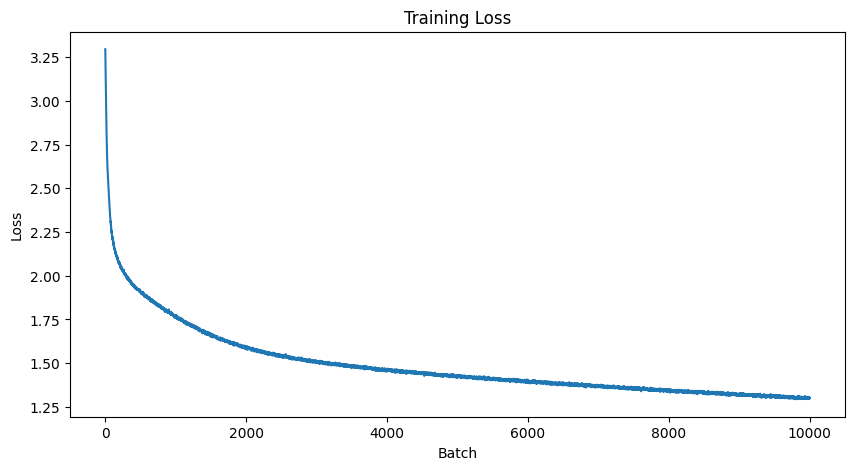

yuuzit
yujurneke
dijah
yumana
yukia
yumani
yumzu
yxevil
surelyn
yumana


In [6]:
import numpy as np
from tinygrad.helpers import Timing
from tinygrad import dtypes, nn, Tensor
from tinygrad.nn.optim import AdamW
from tinygrad import TinyJit
import tqdm
from typing import List, Callable
import matplotlib.pyplot as plt
import random

with open('./names.txt') as f:
    words = f.read().splitlines()
random.seed(42)
random.shuffle(words)

chars = sorted(set(''.join(words)))
stoi = {ch: i + 1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}

block_size = 8
embedding_size = 24

def build_dataset(words, block_size, stoi):
    X, Y = [], []
    context = [0] * block_size
    for word in words:
        for ch in word + '.':
            X.append(context.copy())
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    return Tensor(X), Tensor(Y)

n1, n2 = int(0.8 * len(words)), int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1], block_size, stoi)
Xdev, Ydev = build_dataset(words[n1:n2], block_size, stoi)
Xtest, Ytest = build_dataset(words[n2:], block_size, stoi)

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    def __call__(self, x: Tensor) -> Tensor: 
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1: 
            x = x.squeeze(1)
        self.out = x
        return x

class BatchNormWrapper:
    def __init__(self, size):
        self.batchnorm = nn.BatchNorm(size)
    
    def __call__(self, x: Tensor) -> Tensor:
        original_shape = x.shape
        batch_size = x.shape[0]
        x_reshaped = x.reshape(batch_size, -1)
        normalized_x = self.batchnorm(x_reshaped)
        return normalized_x.reshape(original_shape)

class Model:
    def __init__(self):
        self.layers: List[Callable[[Tensor], Tensor]] = [
            FlattenConsecutive(2), nn.Linear(2*embedding_size, 128, bias=False), BatchNormWrapper(512), Tensor.tanh,
            FlattenConsecutive(2), nn.Linear(2*128, 128, bias=False), BatchNormWrapper(256), Tensor.tanh,
            FlattenConsecutive(2), nn.Linear(2*128, 128, bias=False), BatchNormWrapper(128), Tensor.tanh,
            nn.Linear(128, 27, bias=False),
        ]
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                layer.weight = Tensor.randn(*layer.weight.shape) * 0.001
            
    def __call__(self, x: Tensor) -> Tensor:
        return x.sequential(self.layers)
    
    def sample_names(self, num_samples: int) -> List[str]:
        names = []
        for _ in range(num_samples):
            context = [0] * block_size
            name = ""
            while True:
                X = Tensor(np.array([context]))
                embeddings = character_embeddings[X]
                logits = self(embeddings)
                probs = logits.softmax()
                next_char_probs = probs.numpy().flatten()
                next_char = np.random.choice(len(next_char_probs), p=next_char_probs)
                if next_char == 0:
                    break
                name += itos.get(next_char, '')
                context = context[1:] + [next_char]
            names.append(name)
        return names

character_embeddings = Tensor.randn(27, embedding_size) * 0.001
model = Model()

learning_rate = 0.001
opt = AdamW(nn.state.get_parameters(model), lr=learning_rate)

@TinyJit
def training_step(Xb, Yb):
    embeddings = character_embeddings[Xb]
    logits = model(embeddings)
    loss = logits.sparse_categorical_crossentropy(Yb)
    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss

losses = []
with Tensor.train():
    progress_bar = tqdm.tqdm(range(10000), desc="Training", unit="batch", ncols=100, leave=True)
    for _ in progress_bar:
        ix = Tensor.randint(131072, low=0, high=Xtrain.shape[0])
        loss = training_step(Xtrain[ix], Ytrain[ix])
        loss_value = loss.numpy()
        losses.append(loss_value)
        progress_bar.set_postfix({"Loss": f"{loss_value:.4f}"}, refresh=True)

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

sampled_names = model.sample_names(10)
for name in sampled_names:
    print(name)

#Overfit. I went overboard with the H100 (╥﹏╥). Leaving this here as a lesson to myself.

In [28]:
embeddings_test = character_embeddings[Xtest]
logits_test = model(embeddings_test)
test_loss = logits_test.sparse_categorical_crossentropy(Ytest)
print(f"Test Loss: {test_loss.numpy():.4f}")

Test Loss: 3.0127
